In [206]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
import pulp 
import math
import numba as nb

In [207]:
url='https://www.janestreet.com/puzzles/block-party-2/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:11]))

Fill each cell with a positive integer such that integers do not repeat within any row, column, or outlined region. Within each region, one cell must be equal to the product of the other cells, and these “product” cells may not share edges with “product” cells from other regions. (See the example.) The answer to this month’s puzzle is the smallest possible sum for the “product” cells.


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/12/20181203_block_party_2.png" width="300" height="300">

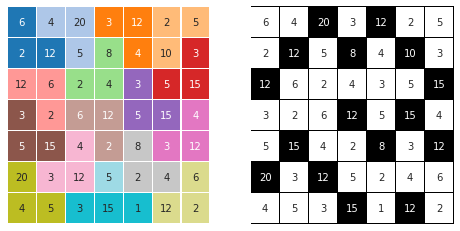

In [208]:
# First thoughts
# 1 cannot be in any of the 3 hooks, so must be in the 4
# reduce the problem to fitting the 3 hooks by
# set one of the cells in the 4 hook to one and solve from there (set it as hook 16)

groups=np.array([[ 0,  1,  1,  2,  2,  3,  3],
                 [ 0,  0,  1,  4,  2,  3,  5],
                 [ 6,  6,  4,  4,  7,  5,  5],
                 [ 8,  6,  9,  9,  7,  7, 10],
                 [ 8,  8, 11,  9, 12, 10, 10],
                 [13, 11, 11, 16, 12, 12, 14],
                 [13, 13, 15, 15, 15, 14, 14]],dtype=int)

fixed =np.zeros((7,7),dtype=int)
fixed[groups==16] = 1

# from the published solution
solution = np.array([[ 6,  4, 20,  3, 12,  2,  5],
                     [ 2, 12,  5,  8,  4, 10,  3],
                     [12,  6,  2,  4,  3,  5, 15],
                     [ 3,  2,  6, 12,  5, 15,  4],
                     [ 5, 15,  4,  2,  8,  3, 12],
                     [20,  3, 12,  5,  2,  4,  6],
                     [ 4,  5,  3, 15,  1, 12,  2]
                    ],dtype =int)

def grid_print(groups,numbers):
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax1 = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=0.25,ax=ax[0])
    ax1.axis("off")
    ax2 =sns.heatmap(np.isin(numbers, [8,10,12,15,20]),annot=x,cbar=False,cmap="Greys",fmt="",linewidths=0.25,ax=ax[1],linecolor ='k')
    ax2.axis("off")
    
grid_print(groups,solution)



In [209]:
# 49 cells - 16 totals - the celll with 1 = 32 to fill
# so 7 x (2,3,4,5) + 6 x 4
# how do we arrange those to give the lowest total with all the constraints
# solve that and output as possible cells

combinations = {(x,y):x*y for x,y  in itertools.combinations([2,3,4,5,6],2)}

prob = pulp.LpProblem("GetTiles",pulp.LpMinimize)
x = pulp.LpVariable.dicts("Combination",combinations.keys(),lowBound=0,upBound=7, cat='Integer') 

# objective
prob += pulp.lpSum([combinations[key]*x[key] for key in combinations])
# constraint 16 hoooks
prob += pulp.lpSum([x[key] for key in combinations]) == 16

# constraints for the numbers - can't have more than 7 of any one
totals = [7,7,7,7,4]
numbs =  [2,3,4,5,6]
for i in range(len(totals)):
    prob += pulp.lpSum([(numbs[i]  in key)*x[key] for key in combinations]) == totals[i]
    
# constraints for the totals - can't have more than 7 of any total (need to work out a nicer way of doing this)
    prob += pulp.lpSum([(combinations[key] ==12)*x[key] for key in combinations]) <= 7
    

prob.solve()
print("Total is: ",np.sum([combinations[key]*x[key].varValue for key in combinations]))

print("The hooks to use are :")
result_dict ={key:x[key].varValue for key in combinations}
display(result_dict)

possible_cells = []

for (a,b) in result_dict:
    count = result_dict[(a,b)]
    #for i in range(int(count)):
    if count > 0:
        possible_cells.append([a,b,a*b])

Total is:  210.0
The hooks to use are :


{(2, 3): 0.0,
 (2, 4): 2.0,
 (2, 5): 1.0,
 (2, 6): 4.0,
 (3, 4): 3.0,
 (3, 5): 4.0,
 (3, 6): 0.0,
 (4, 5): 2.0,
 (4, 6): 0.0,
 (5, 6): 0.0}

In [212]:
# not a great solver. Doing all the neighbour checks and all the count checks on every
# loop is slow. Would be good to track the 2 different hooks with 12 in to cut down 
# possible placements

class Matrix():
    def __init__(self,groups,fixed,possible_cells,early_stop):
        self.groups = groups
        self.fixed = fixed
        self.early_stop = early_stop
        self.solution = []
        self.splits = possible_cells
        self.end_flag = 0
        self.perm_splits = [] 
        #calculate all the permutations of possible groups
        for split in self.splits:
            self.perm_splits += [list(i) for i in itertools.permutations(split)]
        
    # solve by backtracking    
    def solve(self):
        if self.end_flag == 0:
            for group in range(16):
                if 0 in self.fixed[self.groups== group]:
                    for perm in self.perm_splits:
                            if self.possible(group,perm):
                                self.fixed[self.groups== group] = perm
                                self.solve()
                                self.fixed[self.groups== group] = np.array([0,0,0])
                    return
            self.end_flag = self.early_stop
            self.solution.append(fixed)
            grid_print(self.groups,self.fixed) 
            self.counter()

    def possible(self,group,perm):
        test = copy(self.fixed)
        
        #check rows and columns do not contain duplicates
        test[self.groups == group] = perm
        for i in range(7):
            x = test[i,:]
            y = test[:,i]
            row = x[x!=0]
            col = y[y!=0]
            if len(row) != len(set(row)):
                return False 
            if len(col) != len(set(col)):
                return False
            
        # check the number counts as determined above are not
        # breached
        if not self.test_totals(test):
            return False
        
        # check the max cells are not adjacent
        if not self.test_neigh(test):
            return False
            
        return True
   
    @staticmethod
    @nb.njit
    def test_totals(grid):
        # entering the count limitations as calculated above (2 ways of forming 12)
        totals = np.array([2,3,4,5,6,8,10,12,15,20])
        counts = np.array([7,7,7,7,4,2,1 ,7 ,4 ,2 ])
        for i in range(len(totals)):
            if np.sum(np.ravel(grid) == totals[i]) > counts[i]:
                return False  
        return True
    
    @staticmethod
    @nb.njit
    def test_neigh(grid):
        tots = np.array([8,10,12,15,20])
        for row in range(7):
            for col in range(7):
                if grid[row,col] in tots:
                    if row > 0:
                        if grid[row-1,col] in tots:
                            return False
                    if row < 6:
                        if grid[row+1,col] in tots: 
                            return False
                    if col > 0:
                        if grid[row,col-1] in tots: 
                            return False
                    if col < 6:
                        if grid[row,col+1] in tots: 
                            return False 
        return True
     
    def counter(self):
            sum = []
            for i in range(np.max(groups)):
                sum.append(np.max(self.fixed[self.groups==i]))
            print("Sum is : {} ".format(np.sum(sum)))

Sum is : 210 
Found 1 solutions in 9.905801599998085 seconds



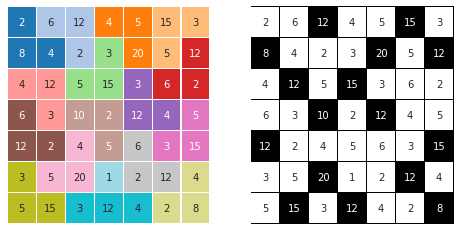

In [213]:
# Find a quick solution
groups=np.array([[ 0,  1,  1,  2,  2,  3,  3],
                 [ 0,  0,  1,  4,  2,  3,  5],
                 [ 6,  6,  4,  4,  7,  5,  5],
                 [ 8,  6,  9,  9,  7,  7, 10],
                 [ 8,  8, 11,  9, 12, 10, 10],
                 [13, 11, 11, 16, 12, 12, 14],
                 [13, 13, 15, 15, 15, 14, 14]],dtype=int)

fixed =np.zeros((7,7),dtype=int)
fixed[groups==16] = 1

start = time.perf_counter()
matrix = Matrix(groups,fixed,possible_cells,early_stop=True)  
#print(len(matrix.perm_splits))
matrix.solve()
print("Found {} solutions in {} seconds\n".format(len(matrix.solution),time.perf_counter()-start))

Sum is : 210 
Found 1 solutions in 139.61629390000053 seconds



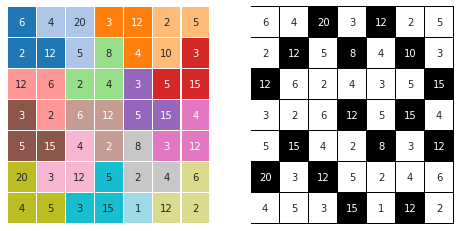

In [205]:
# Find the solution given
groups=np.array([[ 0,  1,  1,  2,  2,  3,  3],
                 [ 0,  0,  1,  4,  2,  3,  5],
                 [ 6,  6,  4,  4,  7,  5,  5],
                 [ 8,  6,  9,  9,  7,  7, 10],
                 [ 8,  8, 11,  9, 12, 10, 10],
                 [13, 11, 11, 15, 12, 12, 14],
                 [13, 13, 15, 15, 16, 14, 14]],dtype=int)


fixed =np.zeros((7,7),dtype=int)
fixed[groups==16] = 1
start = time.perf_counter()
matrix = Matrix(groups,fixed,possible_cells,early_stop=True)  
matrix.solve()
print("Found {} solutions in {} seconds\n".format(len(matrix.solution),time.perf_counter()-start))

In [122]:
url='https://www.janestreet.com/puzzles/solutions/december-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:11]))

We received a lot of entries for this month’s puzzle, but only a few achieved the minimum possible sum of 210 . A few entries this month noted that the constraints in the problem can be shown to imply a lower-bound sum of 210. That being said, finding an arrangement turned out to be quite difficult. To the left is one of the 7 possible configurations that achieve this minimum sum. (And the only one to use ‘1, 3, 5, 15’ in the tetromino; the other 6 all use ‘1, 3, 4, 12’.)


### Puzzle solution
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2019/01/20181228_block_party_2_ans.png" width="250" height="400">